# 5 Levels Of Summarization: Novice to Expert

Summarization is a fundamental building block of many LLM tasks. You'll frequently run into use cases where you would like to distill a large body of text into a succinct set of points.

Depending on the length of the text you'd like to summarize, you have different summarization methods to choose from.

We're going to run through 5 methods for summarization that start with Novice and end up expert. These aren't the only options, feel free to make up your own. If you find another one you like please share it with the community.

**5 Levels Of Summarization:**
1. **Summarize a couple sentences** - Basic Prompt
2. **Summarize a couple paragraphs** - Prompt Templates
3. **Summarize a couple pages** - Map Reduce
4. **Summarize an entire book** - Best Representation Vectors
5. **Summarize an unknown amount of text** - Agents

First let's import our OpenAI API Key (best practice is to have this as an environment variable but showing it here for clarity)

In [2]:
# openai_api_key = 'YourAPIKey'
from dotenv import load_dotenv
load_dotenv()

True

## Level 1: Basic Prompt - Summarize a couple sentences

If you just have a few sentences you want to one-off summarize you can use a simple prompt and copy and paste your text.

This method isn't scalable and only practical for a few use cases...the perfect level #1!

In [3]:
from langchain import OpenAI

In [4]:
llm = OpenAI(temperature=0)

The important part is to provide instructions for the LLM to know what to do. In thise case I'm telling the model I want a summary of the text below

In [5]:
prompt = """
Please provide a summary of the following text

TEXT:
Philosophy (from Greek: φιλοσοφία, philosophia, 'love of wisdom') \
is the systematized study of general and fundamental questions, \
such as those about existence, reason, knowledge, values, mind, and language. \
Some sources claim the term was coined by Pythagoras (c. 570 – c. 495 BCE), \
although this theory is disputed by some. Philosophical methods include questioning, \
critical discussion, rational argument, and systematic presentation.
"""

In [6]:
num_tokens = llm.get_num_tokens(prompt)
print (f"Our prompt has {num_tokens} tokens")

Our prompt has 121 tokens


In [7]:
output = llm(prompt)
print (output)


Philosophy is a systematized study of general and fundamental questions about existence, reason, knowledge, values, mind, and language. It is believed to have been coined by Pythagoras, and its methods include questioning, critical discussion, rational argument, and systematic presentation.


Woof 🐶, that summary is still hard to understand. Let me add to my instructions so that the output is easier to understand. I'll tell it to explain it to me like a 5 year old.

In [8]:
prompt = """
Please provide a summary of the following text.
Please provide your output in a manner that a 5 year old would understand

TEXT:
Philosophy (from Greek: φιλοσοφία, philosophia, 'love of wisdom') \
is the systematized study of general and fundamental questions, \
such as those about existence, reason, knowledge, values, mind, and language. \
Some sources claim the term was coined by Pythagoras (c. 570 – c. 495 BCE), \
although this theory is disputed by some. Philosophical methods include questioning, \
critical discussion, rational argument, and systematic presentation.
"""

In [9]:
num_tokens = llm.get_num_tokens(prompt)
print (f"Our prompt has {num_tokens} tokens")

Our prompt has 137 tokens


In [10]:
output = llm(prompt)
print (output)


Philosophy is about asking questions and trying to figure out the answers. It is about thinking about things like existence, knowledge, and values. People have been doing this for a very long time, and it is still done today.


Nice! That's much better, but let's look at something we can automate a bit more

## Level 2: Prompt Templates - Summarize a couple paragraphs

Prompt templates are a great way to dynamically place text within your prompts. They are like [python f-strings](https://realpython.com/python-f-strings/) but specialized for working with language models.

We're going to look at 2 short Paul Graham essays

In [11]:
from langchain import OpenAI
from langchain import PromptTemplate
import os

In [12]:
paul_graham_essays = ['../data/PaulGrahamEssaySmall/getideas.txt', '../data/PaulGrahamEssaySmall/noob.txt']

essays = []

for file_name in paul_graham_essays:
    with open(file_name, 'r') as file:
        essays.append(file.read())

Let's print out a preview of the essays to see what they look like

In [13]:
for i, essay in enumerate(essays):
    print (f"Essay #{i+1}: {essay[:300]}\n")

Essay #1: January 2023(Someone fed my essays into GPT to make something that could answer
questions based on them, then asked it where good ideas come from.  The
answer was ok, but not what I would have said. This is what I would have said.)The way to get new ideas is to notice anomalies: what seems strange,


Essay #2: January 2020When I was young, I thought old people had everything figured out.
Now that I'm old, I know this isn't true.I constantly feel like a noob. It seems like I'm always talking to
some startup working in a new field I know nothing about, or reading
a book about a topic I don't understand well



Next let's create a prompt template which will hold our instructions and a placeholder for the essay. In this example I only want a 1 sentence summary to come back

In [14]:
template = """
Please write a one sentence summary of the following text:

{essay}
"""

prompt = PromptTemplate(
    input_variables=["essay"],
    template=template
)

Then let's loop through the 2 essays and pass them to our LLM. I'm applying .strip() on the summaries to remove the white space on the front and back of the output

In [15]:
for essay in essays:
    summary_prompt = prompt.format(essay=essay)
    
    num_tokens = llm.get_num_tokens(summary_prompt)
    print (f"This prompt + essay has {num_tokens} tokens")
    
    summary = llm(summary_prompt)
    
    print (f"Summary: {summary.strip()}")
    print ("\n")

This prompt + essay has 205 tokens
Summary: A good way to get new ideas is to look for anomalies at the frontiers of knowledge.


This prompt + essay has 500 tokens
Summary: This text explores the idea that feeling like a "noob" is actually beneficial, as it is inversely correlated with actual ignorance and encourages us to discover new things.




## Level 3: Map Reduce - Summarize a couple pages multiple pages

If you have multiple pages you'd like to summarize, you'll likely run into a token limit. Token limits won't always be a problem, but it is good to know how to handle them if you run into the issue.

The chain type "Map Reduce" is a method that helps with this. You first generate a summary of smaller chunks (that fit within the token limit) and then you get a summary of the summaries.\

Check out [this video](https://www.youtube.com/watch?v=f9_BWhCI4Zo) for more information on how chain types work

In [16]:
from langchain import OpenAI
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [17]:
paul_graham_essay = '../data/PaulGrahamEssays/startupideas.txt'

with open(paul_graham_essay, 'r') as file:
    essay = file.read()

Let's see how many tokens are in this essay

In [18]:
llm.get_num_tokens(essay)

9604

That's too many, let's split our text up into chunks so they fit into the prompt limit. I'm going a chunk size of 10,000 characters. 

> You can think of tokens as pieces of words used for natural language processing. For English text, **1 token is approximately 4 characters** or 0.75 words. As a point of reference, the collected works of Shakespeare are about 900,000 words or 1.2M tokens.

This means the number of tokens we should expect is 10,000 / 4 = ~2,500 token chunks. But this will vary, each body of text/code will be different

In [19]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n"], chunk_size=10000, chunk_overlap=500)

docs = text_splitter.create_documents([essay])

In [20]:
num_docs = len(docs)

num_tokens_first_doc = llm.get_num_tokens(docs[0].page_content)

print (f"Now we have {num_docs} documents and the first one has {num_tokens_first_doc} tokens")

Now we have 5 documents and the first one has 2090 tokens


Great, assuming that number of tokens is consistent in the other docs we should be good to go. Let's use LangChain's [load_summarize_chain](https://python.langchain.com/en/latest/use_cases/summarization.html) to do the `map_reducing` for us. We first need to initialize our chain

In [22]:
summary_chain = load_summarize_chain(llm=llm, chain_type='map_reduce',
                                     verbose=True # Set verbose=True if you want to see the prompts being used
                                    )

Now actually run it

In [23]:
output = summary_chain.run(docs)



> Entering new MapReduceDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"Want to start a startup?  Get funded by
Y Combinator.




November 2012The way to get startup ideas is not to try to think of startup
ideas.  It's to look for problems, preferably problems you have
yourself.The very best startup ideas tend to have three things in common:
they're something the founders themselves want, that they themselves
can build, and that few others realize are worth doing.  Microsoft,
Apple, Yahoo, Google, and Facebook all began this way.
ProblemsWhy is it so important to work on a problem you have?  Among other
things, it ensures the problem really exists.  It sounds obvious
to say you should only work on problems that exist.  And yet by far
the most common mistake startups make is to solve problems no one
has.I made it myself.  In 1995 I started a company to put art galleries
online.  But galleries didn't want 

In [24]:
output

' Y Combinator explains that the best startup ideas come from looking for problems, preferably ones that the founders have themselves. Sam Altman and Paul Buchheit provide advice on how to come up with startup ideas on demand, such as looking in areas of expertise, talking to people about their needs, and looking for waves and gaps in the market. They also suggest living in the future and building what seems interesting. Several successful entrepreneurs have provided input on this essay.'

This summary is a great start, but I'm more of a bullet point person. I want to get my final output in bullet point form.

In order to do this I'm going to use custom promopts (like we did above) to instruct the model on what I want.

The map_prompt is going to stay the same (just showing it for clarity), but I'll edit the combine_prompt.

In [25]:
map_prompt = """
Write a concise summary of the following:
"{text}"
CONCISE SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [26]:
combine_prompt = """
Write a concise summary of the following text delimited by triple backquotes.
Return your response in bullet points which covers the key points of the text.
```{text}```
BULLET POINT SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [27]:
summary_chain = load_summarize_chain(llm=llm,
                                     chain_type='map_reduce',
                                     map_prompt=map_prompt_template,
                                     combine_prompt=combine_prompt_template,
#                                      verbose=True
                                    )

In [28]:
output = summary_chain.run(docs)

In [29]:
print (output)

- Y Combinator suggests that the best startup ideas come from looking for problems, preferably ones that the founders have themselves.
- Good ideas should appeal to a small number of people who need it urgently.
- College students should use their college experience to prepare themselves for the future and build things with other students.
- Look in areas of expertise, talk to people about their needs, and look for waves and gaps in the market.
- Look for ideas that are unsexy or involve schleps, and make other people's problems your own.
- Sam Altman points out that taking the time to come up with a good startup idea is a better strategy than coming up with a mediocre one.
- Paul Buchheit suggests that trying to sell a bad idea can lead to better ideas.
- Steve Wozniak's success is attributed to him solving his own problems.


## Level 4: Best Representation Vectors - Summarize an entire book

In the above method we pass the entire document (all 9.5K tokens of it) to the LLM. But what if you have more tokens than that?

What if you had a book you wanted to summarize? Let's load one up, we're going to load [Into Thin Air](https://www.amazon.com/Into-Thin-Air-Personal-Disaster/dp/0385494785) about the 1996 Everest Disaster

In [30]:
from langchain.document_loaders import PyPDFLoader

# Load the book
loader = PyPDFLoader("../data/IntoThinAirBook.pdf")
pages = loader.load()

# Cut out the open and closing parts
pages = pages[26:277]

# Combine the pages, and replace the tabs with spaces
text = ""

for page in pages:
    text += page.page_content
    
text = text.replace('\t', ' ')

In [31]:
num_tokens = llm.get_num_tokens(text)

print (f"This book has {num_tokens} tokens in it")

This book has 139472 tokens in it


Wow, that's over 100K tokens, even [GPT 32K](https://help.openai.com/en/articles/7127966-what-is-the-difference-between-the-gpt-4-models) wouldn't be able to handle that in one go. At [0.03 per 1K prompt tokens](https://help.openai.com/en/articles/7127956-how-much-does-gpt-4-cost), this would cost us $4.17 just for the prompt alone.

So how do we do this without going through all the tokens? Pick random chunks? Pick equally spaced chunks?

I kicked off a [twitter thread](https://twitter.com/GregKamradt/status/1653060004226924544) with a proposed solution to see if I was off base. I'm calling it the Best Representation Vectors method (not sure if a name already exists for it).

**Goal:** Chunk your book then get embeddings of the chunks. Pick a subset of chunks which represent a wholistic but diverse view of the book. Or another way, is there a way to pick the top 10 passages that describe the book the best?

Once we have our chunks that represent the book then we can summarize those chunks and hopefully get a pretty good summary.

Keep in mind there are tools that would likely do this for you, and with token limits increasing this won't be a problem for long. But if you want to do it from scratch this might help.

This is most definitely not the optimal answer, but it's my take on it for now! If the [clustering](https://scikit-learn.org/stable/modules/clustering.html) experts wanna help improve it that would be awesome.

**The BRV Steps:**
1. Load your book into a single text file
2. Split your text into large-ish chunks
3. Embed your chunks to get vectors
4. Cluster the vectors to see which are similar to each other and likely talk about the same parts of the book
5. Pick embeddings that represent the cluster the most (method: closest to each cluster centroid)
6. Summarize the documents that these embeddings represent

Another way to phrase this process, "Which ~10 documents from this book represent most of the meaning? I want to build a summary off those."

Note: There will be a bit of information loss, but show me a summary of a whole book that doesn't have information loss ;)

In [33]:
# Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model
from langchain.chat_models import ChatOpenAI

# Embedding Support
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans

I'm going to initialize two models, gpt-3.5 and gpt4. I'll use gpt 3.5 for the first set of summaries to reduce cost and then gpt4 for the final pass which should hopefully increase the quality.

In [34]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=10000, chunk_overlap=3000)

docs = text_splitter.create_documents([text])

In [35]:
num_documents = len(docs)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 78 documents


Let's get our embeddings of those 78 documents

In [37]:
embeddings = OpenAIEmbeddings()

vectors = embeddings.embed_documents([x.page_content for x in docs])

Now let's cluster our embeddings. There are a ton of clustering algorithms you can chose from. Please try a few out to see what works best for you!

In [38]:
# Assuming 'embeddings' is a list or array of 1536-dimensional embeddings

# Choose the number of clusters, this can be adjusted based on the book's content.
# I played around and found ~10 was the best.
# Usually if you have 10 passages from a book you can tell what it's about
num_clusters = 11

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Here are the clusters that were found. It's interesting to see the progression of clusters throughout the book. This is expected because as the plot changes you'd expect different clusters to emerge due to different semantic meaning

In [39]:
kmeans.labels_

array([ 4,  4,  4,  4,  4,  4,  7,  5,  5,  9,  9,  9,  9,  7,  7,  7,  7,
        9,  9,  9,  5,  5,  5,  5,  9,  0,  0,  0,  5,  3,  3,  5,  3,  7,
        0,  5,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  2,  2,  3,  3,  2,
        2,  2,  2,  1,  1,  1,  1,  1,  1,  3,  2,  2,  9,  9, 10, 10, 10,
       10, 10,  8,  8,  8,  6,  6,  8,  5,  8])

This is sweet, but whenever you have a clustering exercise, it's hard *not* to graph them. Make sure you add colors.

We also need to do dimensionality reduction to reduce the vectors from 1536 dimensions to 2 (this is sloppy data science but we are working towards the 80% solution)

In [47]:
len(vectors[0])

1536

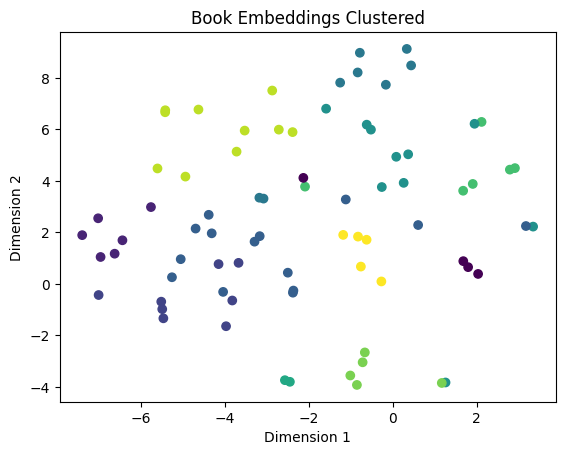

In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))  # converted vectors to np arrays

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

Awesome, not perfect, but pretty good directionally. Now we need to get the vectors which are closest to the cluster centroids (the center).

The function below is a quick way to do that (w/ help from ChatGPT)

In [49]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):
    
    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)
    
    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)
    
    # Append that position to your closest indices list
    closest_indices.append(closest_index)

Now sort them (so the chunks are processed in order)

In [51]:
selected_indices = sorted(closest_indices)
selected_indices

[0, 12, 15, 22, 26, 41, 52, 56, 65, 71, 74]

It's intersting to see which chunks pop up at most descriptive. How does your distribution look?

Let's create our custom prompts. I'm going to use gpt4 (which has a bigger token limit) for the combine step so I'm asking for long summaries in the map step to reduce the information loss.

In [52]:
llm3 = ChatOpenAI(temperature=0,
                 max_tokens=1000,
                 model='gpt-3.5-turbo'
                )

In [53]:
map_prompt = """
You will be given a single passage of a book. This section will be enclosed in triple backticks (```)
Your goal is to give a summary of this section so that a reader will have a full understanding of what happened.
Your response should be at least three paragraphs and fully encompass what was said in the passage.

```{text}```
FULL SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

I kept getting a timeout errors so I'm actually going to do this map reduce manually

In [54]:
map_chain = load_summarize_chain(llm=llm3,
                             chain_type="stuff",
                             prompt=map_prompt_template)

Then go get your docs which the top vectors represented.

In [55]:
selected_docs = [docs[doc] for doc in selected_indices]

In [59]:

for i, doc in enumerate(selected_docs):
    num_tokenn = llm.get_num_tokens(map_prompt_template.format(text=doc))
    print(f'{i}: {num_tokenn}')

0: 2677
1: 2791
2: 2731
3: 2708
4: 2790
5: 2784
6: 2961
7: 2974
8: 2727
9: 2728
10: 2666


Let's loop through our selected docs and get a good summary for each chunk. We'll store the summary in a list.

In [60]:
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):
    
    # Go get a summary of the chunk
    chunk_summary = map_chain.run([doc])
    
    # Append that summary to your list
    summary_list.append(chunk_summary)
    
    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:250]} \n")

Summary #0 (chunk #0) - Preview: In this passage, the author describes their experience reaching the summit of Mount Everest on May 10, 1996. They explain that despite the physical and mental challenges they faced, they were not able to fully appreciate the moment due to exhaustion  

Summary #1 (chunk #12) - Preview: In this passage, the author describes the dangerous journey of Tenzing, a climber who fell into a crevasse on the glacier. Due to the high altitude, it was too risky to evacuate him by helicopter, so a massive effort was required to carry him down to 

Summary #2 (chunk #15) - Preview: This passage provides insight into the character of Scott Fischer, a climber who is seeking recognition and respect for his accomplishments. He has gained some recognition through his ascent of Everest without supplemental oxygen and his efforts in c 

Summary #3 (chunk #22) - Preview: This passage provides a glimpse into the different teams and climbers attempting to summit Mount Everest. 

Great, now that we have our list of summaries, let's get a summary of the summaries

In [71]:
summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 3688 tokens


In [77]:
llm4 = ChatOpenAI(temperature=0,
                #  max_tokens=3000,
                #  model='gpt-4',
                model='gpt-3.5-turbo',
                request_timeout=120
                )

In [78]:
combine_prompt = """
You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of what happened in the story.
The reader should be able to grasp what happened in the book.

```{text}```
VERBOSE SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [79]:
reduce_chain = load_summarize_chain(llm=llm4,
                             chain_type="stuff",
                             prompt=combine_prompt_template,
#                              verbose=True # Set this to true if you want to see the inner workings
                                   )

Run! Note this will take a while

In [80]:
output = reduce_chain.run([summaries])

In [56]:
print (output)

In this story, the author recounts their experience as part of a New Zealand-based team attempting to summit Mount Everest on May 10, 1996. Despite months of anticipation, the author finds themselves unable to fully appreciate the achievement due to extreme exhaustion, lack of sleep, and the effects of high altitude. After a brief moment at the summit, the author begins their descent, encountering a traffic jam of climbers from multiple expeditions. The author's oxygen tank runs out, forcing them to navigate dangerous terrain without supplemental oxygen. Unbeknownst to the climbers, a disaster is about to unfold, resulting in the deaths of eight climbers, including two of the author's teammates.

The story also highlights the challenges and dangers of high-altitude mountaineering, as well as the importance of teamwork and respect for local cultures and customs. The author and their team face various obstacles, including altitude sickness, treacherous terrain, and the reliance on Sherpa

Wow that was a long process, but you get the gist, hopefully we'll see some library abstractions in the coming months that do this automatically for us! Let me know what you think on [Twitter](https://twitter.com/GregKamradt)

## Level 5: Agents - Summarize an unknown amount of text

What if you have an unknown amount of text you need to summarize? This may be a verticalize use case (like law or medical) where more research is required as you uncover the first pieces of information.

We're going to use agents below, this is still a very actively developed area and should be handled with care. Future agents will be able to handle a lot more complicated tasks.

In [99]:
from langchain import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain.utilities import WikipediaAPIWrapper

llm = ChatOpenAI(temperature=1, model='gpt-3.5-turbo') #model_name='gpt-4') # chaptgpt4 -> works with temperature = 0, not with 3.5


We're going to use the Wiki search tool and research multiple topics

In [100]:
wikipedia = WikipediaAPIWrapper()

Let's define our toolkit, in this case it's just one tool

In [101]:
tools = [
    Tool(
        name="Wikipedia",
        func=wikipedia.run,
        description="Useful for when you need to get information from wikipedia about a single topic"
    ),
]

Init our agent

In [102]:
agent_executor = initialize_agent(tools, llm, agent='zero-shot-react-description', verbose=True)

Then let's ask a question that will need multiple documents

In [103]:
output = agent_executor.run("Can you please provide a quick summary of Napoleon Bonaparte? \
                          Then do a separate search and tell me what the commonalities are with Serena Williams")



> Entering new AgentExecutor chain...
I should first search for a quick summary of Napoleon Bonaparte on Wikipedia. Then, I can search for Serena Williams and compare the information to find any commonalities between the two.

Action: Wikipedia
Action Input: "Napoleon Bonaparte"
Observation: Page: Napoleon
Summary: Napoleon Bonaparte (born Napoleone Buonaparte; 15 August 1769 – 5 May 1821), later known by his regnal name Napoleon I, was a French military commander and political leader who rose to prominence during the French Revolution and led successful campaigns during the Revolutionary Wars. He was the leader of the French Republic as First Consul from 1799 to 1804, then of the French Empire as Emperor of the French from 1804 until 1814 and again in 1815. Napoleon's political and cultural legacy endures as a celebrated and controversial leader. He initiated many liberal reforms that have persisted, and is considered one of the greatest military commanders in history. His campaigns

In [104]:
print (output)

The commonality between Napoleon Bonaparte and Serena Williams is that they both achieved great success in their respective fields and had a significant impact in history.


Awesome, good luck summarizing!